In [1]:
import pandas as pd
import numpy as np
import TS_general_library as tsl
import matplotlib.pyplot as plt
import pdb

%load_ext autoreload
%autoreload 2
# pdb.set_trace()  # This sets a breakpoint


In [2]:
prices = pd.read_csv("Price_data.csv", index_col=0) # Upload data
prices.index = pd.to_datetime(prices.index.astype(str), format='%Y%m%d')  # Index to DatetimeIndex
returns = prices.pct_change() # Compute returns

In [3]:
returns.shape

(2608, 10)

In [4]:
# Find missing trading days
missing_trading_days = tsl.find_missing_trading_days(prices)
print(missing_trading_days)
prices.shape

DatetimeIndex([], dtype='datetime64[ns]', freq='B')


(2608, 10)

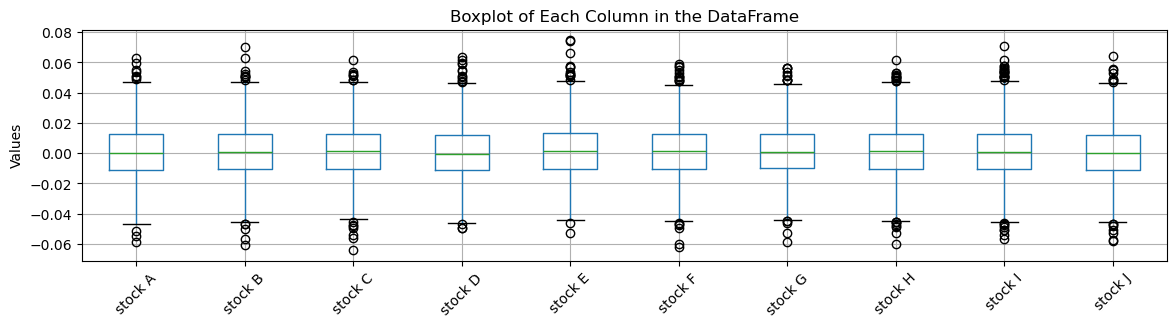

In [5]:
# Generate boxplots for each column in the dataframe
plt.figure(figsize=(14, 3))
returns.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of Each Column in the DataFrame")
plt.ylabel("Values")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

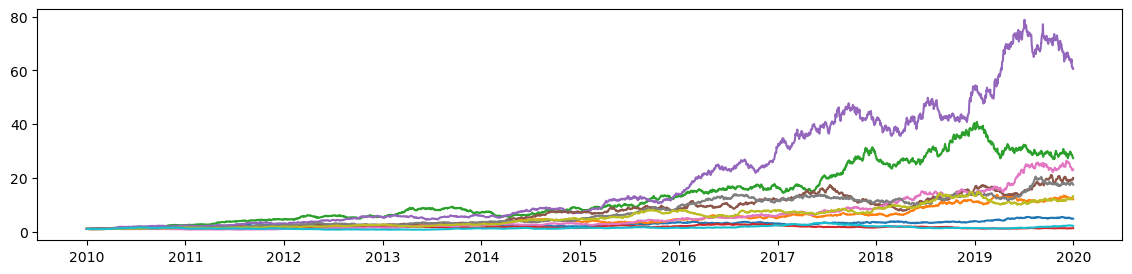

In [6]:
plt.figure(figsize=(14,3))
plt.plot(prices)
plt.show

In [7]:
#Extract Features
features = tsl.compute_features(prices)
# Replace Nans
features = {key: value.bfill() for key, value in features.items()}

In [8]:
features.keys()

dict_keys(['r_1', 'r_5', 'r_10', 'z_10', 'vol_10', 'rv_10', 'vol_q_10', 'rsi_20', 'sma_ratio', 'bb_pct', 'ewma_5', 'ewma_20', 'macd', 'auto_corr_5'])

# Trading Strategy based on RSI and Bollinger Bands 

Mean-Reversion Approach

- Long Entry: RSI < 25 and price below the lower Bollinger Band (oversold).
- Short Entry: RSI > 75 and price above the upper Bollinger Band (overbought).
- Exit Condition: RSI returns to a neutral range (40-60).
- Positions are capped at $100M total exposure.

Conditional Sharpe Ratio: -1.3658


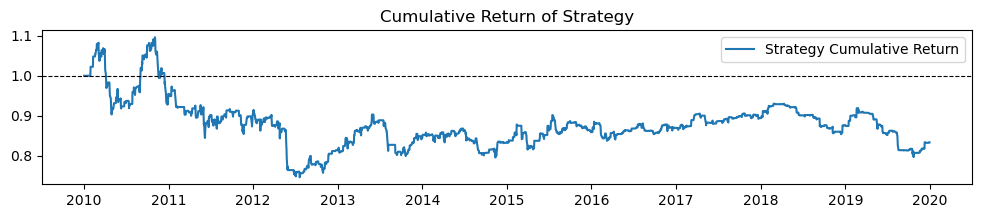

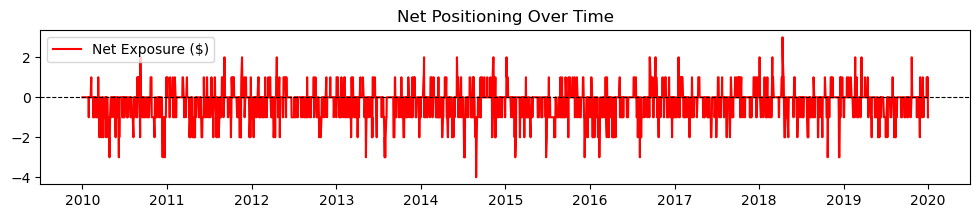

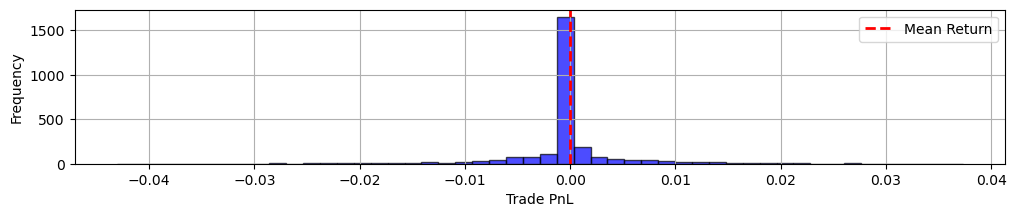

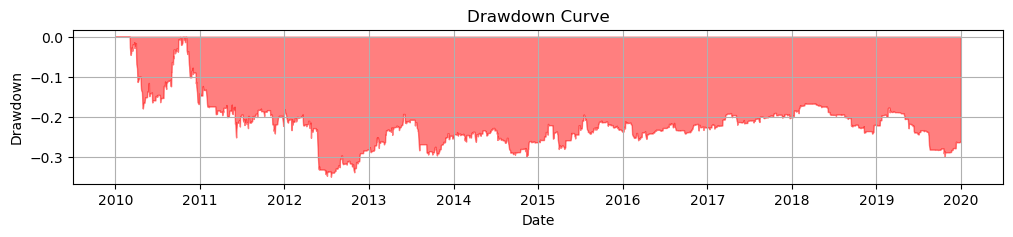

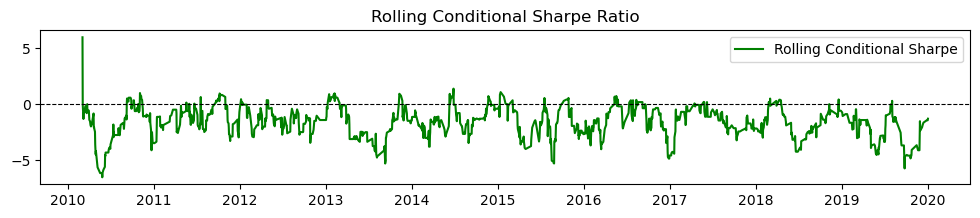

In [24]:
# Define strategy parameters
bollinger_window = 20
bollinger_std = 2
max_capital = 100e6  # $100M max investment

# Compute RSI for all stocks
rsi = features['rsi_20']

# Compute Bollinger Bands
rolling_mean = prices.rolling(bollinger_window).mean()
rolling_std = prices.rolling(bollinger_window).std()
upper_band = rolling_mean + bollinger_std * rolling_std
lower_band = rolling_mean - bollinger_std * rolling_std

# Generate Long & Short signals
long_signal = (rsi < 30) & (prices < lower_band)
short_signal = (rsi > 70) & (prices > upper_band)

# Exit when RSI returns to neutral
exit_signal = (rsi > 40) & (rsi < 60)

# Initialize position matrix (1 for long, -1 for short, 0 otherwise)
position = np.zeros_like(prices)
position[long_signal] = 1
position[short_signal] = -1
position[exit_signal] = 0

# Forward-fill positions to maintain trades until exit condition is met
position = pd.DataFrame(position, index=prices.index, columns=prices.columns)
position.ffill(inplace=True)

# Scale positions to respect the $100M capital constraint
position_size = max_capital / prices  # Dollar allocation per unit of stock price
position_weighted = position * position_size  # Position value in dollars
total_exposure = position_weighted.abs().sum(axis=1)
scaling_factor = np.minimum(1, max_capital / total_exposure)  # Scale down if exceeding $100M
position_weighted = position_weighted.multiply(scaling_factor, axis=0)

# Compute daily marked-to-market returns
daily_returns = position_weighted.shift(1) * returns / max_capital  # Normalize by total capital
daily_returns.fillna(0, inplace=True)  # Ensure no NaNs

# Compute conditional Sharpe Ratio (cSharpe)
active_days = daily_returns[(position != 0).any(axis=1)]
mu = active_days.mean().mean()  # Mean return on active trading days
sigma = active_days.std().mean()  # Standard deviation on active trading days
cSharpe = (mu / sigma) * np.sqrt(252)
# Compute rolling conditional Sharpe ratio for plotting
roll_win = 20
rolling_sharpe = active_days.rolling(window=roll_win, min_periods=1).mean() / active_days.rolling(window=roll_win, min_periods=1).std() * np.sqrt(252)

# Cumulative returns
cumulative_returns = (1 + daily_returns.sum(axis=1)).cumprod()

# Display Conditional Sharpe Ratio
print(f"Conditional Sharpe Ratio: {cSharpe:.4f}")

# Plot results
tsl.plot_strategy_performance(cumulative_returns, position, daily_returns.sum(axis=1), rolling_sharpe.mean(axis=1))


# Momentum and Mean Reversion Strategy

- Uses EWMA for momentum detection.
- Filters trades using mean-reversion thresholds based on rolling volatility.
- Applies risk-based position sizing (inverse volatility weighting).
- Implements a stop-loss mechanism (exits positions on a 2% daily loss).

Conditional Sharpe Ratio: 0.9469


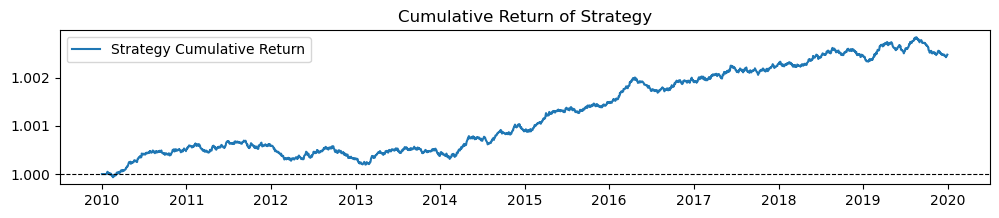

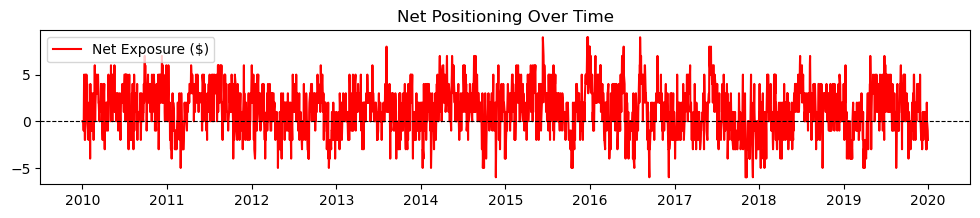

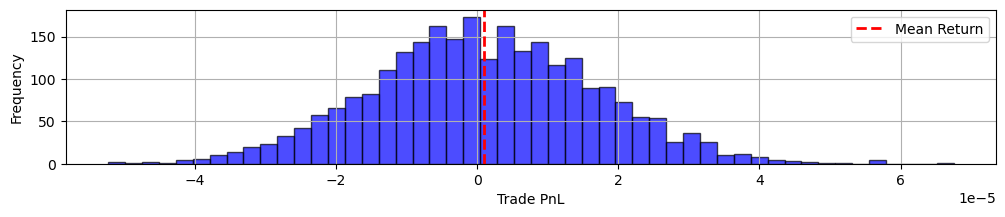

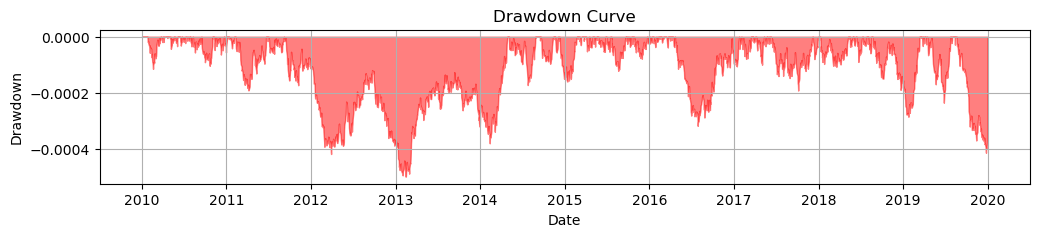

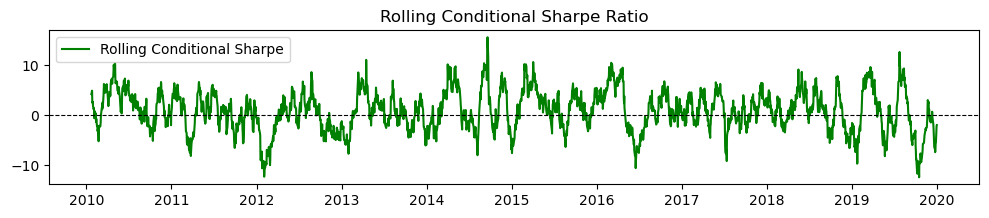

In [27]:
from scipy.optimize import minimize

# Parameters
lookback_momentum = 15  # Initial value for optimization
lookback_reversion = 3   # Initial value for optimization
capital = 100e6  # Max capital
num_stocks = returns.shape[1]

# Adaptive Mean-Reversion Threshold (based on rolling volatility)
volatility = returns.rolling(lookback_reversion).std()
adaptive_threshold = 1.5 * volatility  # Dynamic threshold

# Capital Allocation (Risk-Based Position Sizing)
vol = returns.rolling(lookback_momentum).std()
weight = 1 / vol
weight /= weight.sum()  # Normalize weights
position_size = capital * weight

# Compute momentum signal using Exponential Weighted Moving Average (EWMA)
momentum_signal = returns.ewm(span=lookback_momentum).mean()

# Compute mean-reversion filter based on price deviation
price = (1 + returns).cumprod()  # Construct price series
mean_price = price.rolling(lookback_reversion).mean()
mean_reversion = (price - mean_price) / mean_price  # Normalized deviation

# Generate trading signal (1 for long, -1 for short, 0 for no trade)
signal = np.sign(momentum_signal)

# Apply adaptive mean-reversion filter (filter trades when mean reversion exceeds threshold)
signal *= (mean_reversion.abs() <= adaptive_threshold).astype(int)

# Risk Management: Stop-Loss Mechanism
stop_loss_threshold = -0.02  # 2% daily loss
cumulative_pnl = (signal.shift(1) * returns * position_size).cumsum()
stop_loss_signal = (cumulative_pnl.pct_change() < stop_loss_threshold).astype(int)
signal[stop_loss_signal == 1] = 0  # Exit position when stop loss triggered

# Compute daily PnL
pnl = signal.shift(1) * returns * position_size  # Shift to avoid lookahead bias
portfolio_returns = pnl.sum(axis=1) / capital  # Normalize returns
portfolio_returns[~(signal.shift(1) != 0).any(axis=1)] = 0  # Ensure returns are 0 on no-position days

# Compute cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Compute position-weighted exposure
position_weighted = signal * position_size

# Compute conditional Sharpe ratio
open_positions = (signal.shift(1) != 0).any(axis=1)  # Days with open trades
conditional_returns = portfolio_returns[open_positions]
cSharpe = (conditional_returns.mean() / conditional_returns.std()) * np.sqrt(252)

# Compute rolling conditional Sharpe ratio for plotting
roll_win = 20
rolling_sharpe = conditional_returns.rolling(window=roll_win, min_periods=1).mean() / conditional_returns.rolling(window=roll_win, min_periods=1).std() * np.sqrt(252)

# Display results
print(f"Conditional Sharpe Ratio: {cSharpe:.4f}")

# Plot results
tsl.plot_strategy_performance(cumulative_returns, signal, portfolio_returns, rolling_sharpe)


# Trend-following and mean-reversion hybrid Strategy

The strategy uses walk-forward optimization to find the optimal momentum & mean reversion lookback windows

- Filters the top N assets with the strongest ADX trends.
- Selects from those with the highest recent mean returns.
- Mean Reversion Filter: Checks whether price deviation from moving average is below a rolling quantile threshold.
- Trend Regime Adjustment: Ensures trend-following only in persistent trends (ADX > 25 and Hurst > 0.5).
- RSI Overbought/Oversold Filter: Prevents entering at extreme price points.
- Stop-Loss: Exits trades if cumulative 5-day return < -2%.
- Adaptive Holding Period: Stops trading if signals reverse significantly.

Optimal Momentum Lookback: 20
Optimal Mean Reversion Lookback: 6



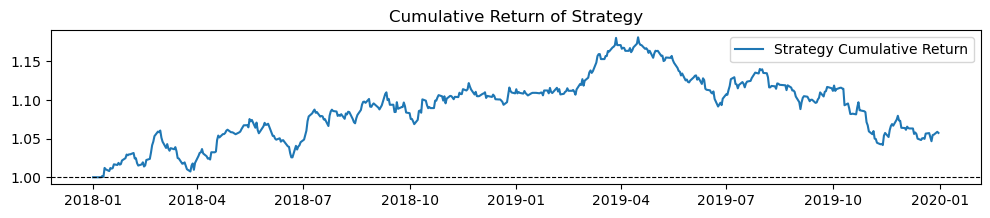

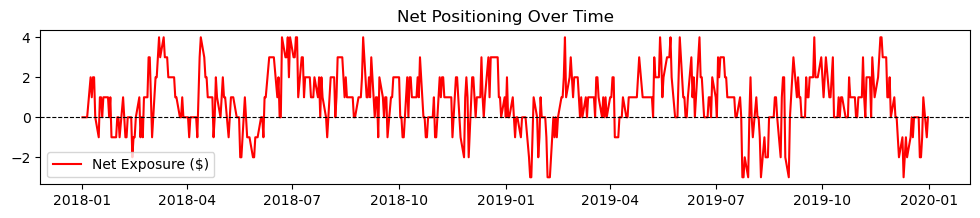

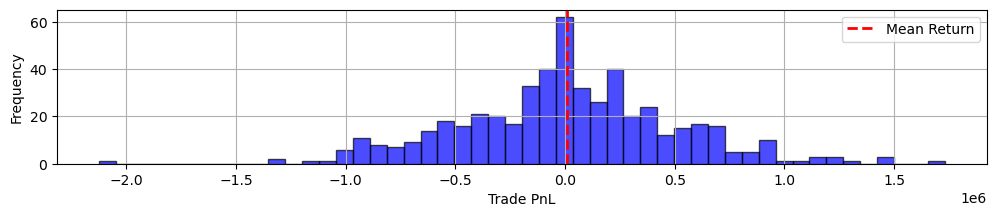

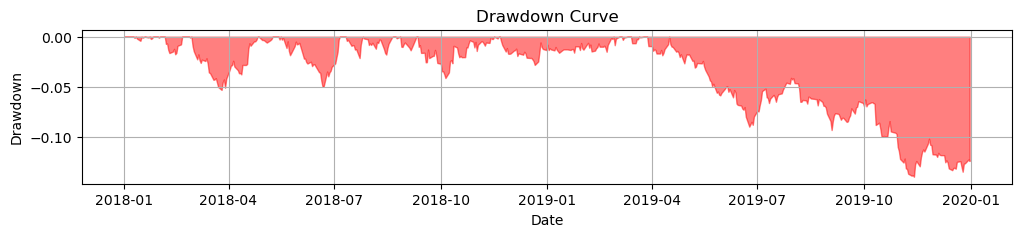

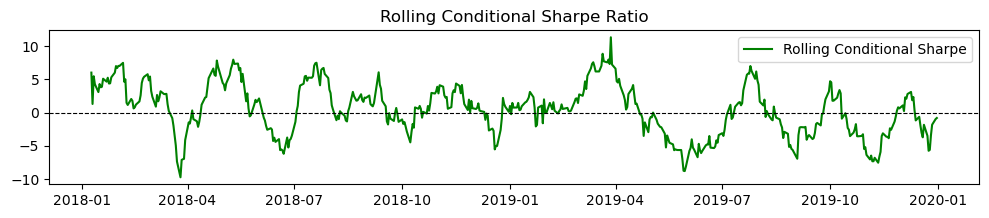


Out-of-Sample Conditional Sharpe Ratio: 0.3527


In [26]:
from skopt import gp_minimize
from skopt.space import Integer
import warnings

warnings.simplefilter("ignore", category=UserWarning)

# Parameters
capital = 100e6  # Max capital
num_selected_assets = 5  # Number of top trending assets to trade

# Function to compute ADX (Trend Strength Indicator)
def compute_adx(high, low, close, period=20):
    tr = np.maximum(high - low, np.maximum(abs(high - close.shift()), abs(low - close.shift())))
    atr = tr.rolling(window=period).mean() + 1e-9  # Prevent division by zero
    
    plus_dm = np.where(high.diff() > low.diff(), high.diff(), 0)
    minus_dm = np.where(low.diff() > high.diff(), low.diff(), 0)
    
    plus_di = 100 * (pd.Series(plus_dm).rolling(window=period).sum() / atr)
    minus_di = 100 * (pd.Series(minus_dm).rolling(window=period).sum() / atr)
    
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di + 1e-9))
    adx = dx.rolling(window=period).mean()
    return adx.fillna(20)  # Neutral default value

# Function to compute trend persistence
def compute_hurst(ts):
    if len(ts) < 100:
        return 0.5  # Default to random walk behavior
    lags = np.arange(2, min(len(ts) // 2, 100))
    tau = [np.std(ts[lag:] - ts[:-lag]) for lag in lags]
    
    if np.min(tau) == 0:
        return 0.5
    
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

# Function to compute additional factors for strategy
def compute_factors(returns, prices):
    short_vol = returns.rolling(10).std()
    long_vol = returns.rolling(60).std()
    rolling_vol = short_vol.where(short_vol > long_vol, long_vol)
    vol_regime = (rolling_vol > rolling_vol.rolling(60).mean()).astype(int)
    
    adx = prices.apply(lambda x: compute_adx(x.rolling(2).max(), x.rolling(2).min(), x), axis=0)
    hurst_values = returns.apply(compute_hurst, axis=0)
    rsi = features['rsi_20']
    
    return rolling_vol, vol_regime, adx, hurst_values, rsi
    

# Function to select top N trending assets
def select_top_trending_assets(adx, returns):
    avg_returns = returns.rolling(60).mean().iloc[-1]
    top_assets = adx.iloc[-1].nlargest(num_selected_assets).index
    top_assets = avg_returns.loc[top_assets].nlargest(num_selected_assets).index
    return top_assets
    
# Improved strategy performance function
def strategy_performance(params, returns, prices, flag=False):
    lookback_momentum, lookback_reversion = params
    
    # Feature computation
    rolling_vol, vol_regime, adx, hurst_values, rsi = compute_factors(returns, prices)
    
    # Filters the top N assets with the strongest ADX trends
    selected_assets = select_top_trending_assets(adx, returns)
    returns = returns[selected_assets]
    prices = prices[selected_assets]

    # Mean Reversion Filter: Checks whether price deviation from moving average is below a rolling quantile threshold
    mean_price = prices.rolling(lookback_reversion).mean()
    mean_reversion_signal = (prices - mean_price) / mean_price
    adaptive_threshold = mean_reversion_signal.abs().rolling(40).quantile(0.75).ffill().bfill()

    # Momentum Signal: Exponential weighted moving average of past returns
    momentum_signal = returns.ewm(span=lookback_momentum).mean()
    signal = np.sign(momentum_signal)
    
    # Trend Regime Adjustment: Ensures trend-following only in persistent trends (ADX > 25 and Hurst > 0.5).
    signal *= (mean_reversion_signal.abs() <= adaptive_threshold).astype(int)
    trend_regime = (adx[selected_assets] > 25) & (hurst_values[selected_assets] > 0.5)
    signal[trend_regime] = np.sign(momentum_signal)
    
    # RSI Overbought/Oversold Filter: Prevents entering at extreme price points.
    signal[(rsi[selected_assets] > 70) & (signal > 0)] = 0  # Overbought filter
    signal[(rsi[selected_assets] < 30) & (signal < 0)] = 0  # Oversold filter
    
    # Stop-loss: If cumulative 5-day returns < -2%
    stop_loss = (returns.rolling(5).sum() < -0.02).astype(int)
    signal[stop_loss == 1] = 0
    
    # Adaptive holding period: Exit if stop-loss is triggered or signal reverses significantly
    exit_signal = (stop_loss == 1) | (signal.diff().abs() > 1)
    signal[exit_signal] = 0
    
    # Volatility-weighted position sizing
    trend_strength = adx[selected_assets].iloc[-1].astype(float) / adx[selected_assets].iloc[-1].sum()
    risk_weight = ((1 / (rolling_vol[selected_assets].iloc[-1].astype(float) + 1e-6)) * trend_strength).clip(0.01, 0.2)
    risk_weight /= risk_weight.sum()  # Normalize weights
    position_size = (capital * risk_weight)
    
    total_position_value = (position_size.abs()).sum()
    if total_position_value > capital:
        position_size *= (capital / total_position_value)  # Scale down proportionally
        
    pnl = signal.shift(1) * returns * position_size
    portfolio_returns = pnl.sum(axis=1) / capital

    # Compute rolling conditional Sharpe ratio for plotting
    roll_win = 20
    rolling_sharpe = portfolio_returns.rolling(window=roll_win, min_periods=1).mean() / portfolio_returns.rolling(window=roll_win, min_periods=1).std() * np.sqrt(252)

    if flag:
        tsl.plot_strategy_performance(portfolio_returns.cumsum()+1, signal, pnl.sum(axis=1), rolling_sharpe)
    
    return -np.mean(portfolio_returns) / np.std(portfolio_returns) * np.sqrt(252)


# Walk-forward optimization
def optimize_strategy(returns, prices):
    def objective(params):
        return strategy_performance(params, returns, prices, False)
    
    search_space = [Integer(10, 20), Integer(2, 10)]  # Lookback periods
    result = gp_minimize(objective, search_space, n_calls=30, random_state=42)
    return result.x  # Best parameters

##### Out-of-Sample Validation #####
# Split data into training and testing
split_idx = int(len(returns) * 0.8)
train_returns, test_returns = returns.iloc[:split_idx,:], returns.iloc[split_idx:,:]
train_prices, test_prices = prices.iloc[:split_idx,:], prices.iloc[split_idx:,:]

# Example usage (assuming returns and prices DataFrame available)
best_params = optimize_strategy(train_returns, train_prices)

print(f"Optimal Momentum Lookback: {best_params[0]}")
print(f"Optimal Mean Reversion Lookback: {best_params[1]}\n")

# Evaluate on test data
test_cSharpe = -strategy_performance(best_params, test_returns, test_prices, True)
print(f"\nOut-of-Sample Conditional Sharpe Ratio: {test_cSharpe:.4f}")


In [12]:
# pdb.set_trace()